In [1]:
#Project On Potato Leaf Disease
#Farmers every year face economic loss and crop waste due to various diseases in potato plants. Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :
#1. Healthy leaves
#2. Late Blight leaves
#3. Early Blight leaves

In [2]:
import tensorflow as tf #In the command prompt start a python session using the command >python · Import the tensorflow package
from tensorflow.keras import models, layers #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
import matplotlib.pyplot as plt #Most of the Matplotlib utilities lies under the pyplot submodule, and are usually imported under the plt alias

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # 68*32=2176

68

In [7]:
# print individual image
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0]) #3D array

tf.Tensor(
[[[191. 186. 193.]
  [190. 185. 192.]
  [192. 187. 194.]
  ...
  [201. 198. 207.]
  [193. 190. 199.]
  [184. 181. 190.]]

 [[197. 192. 199.]
  [195. 190. 197.]
  [196. 191. 198.]
  ...
  [198. 195. 204.]
  [191. 188. 197.]
  [183. 180. 189.]]

 [[199. 194. 201.]
  [196. 191. 198.]
  [195. 190. 197.]
  ...
  [195. 192. 201.]
  [189. 186. 195.]
  [183. 180. 189.]]

 ...

 [[155. 148. 155.]
  [163. 156. 163.]
  [165. 158. 165.]
  ...
  [142. 139. 146.]
  [135. 132. 139.]
  [149. 146. 153.]]

 [[160. 153. 160.]
  [162. 155. 162.]
  [165. 158. 165.]
  ...
  [146. 143. 150.]
  [149. 146. 153.]
  [147. 144. 151.]]

 [[166. 159. 166.]
  [163. 156. 163.]
  [163. 156. 163.]
  ...
  [141. 138. 145.]
  [150. 147. 154.]
  [131. 128. 135.]]], shape=(256, 256, 3), dtype=float32)


In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    # in output 32 images each images size are 256,256 and 3 for RGB

(32, 256, 256, 3)
[1 1 1 1 1 1 1 1 0 1 0 0 0 1 2 1 0 0 0 1 0 2 1 0 1 1 2 0 2 0 0 2]


#As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

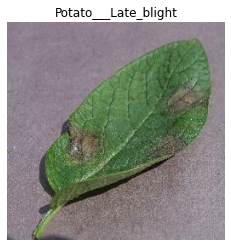

In [9]:
#Visualize images from our dataset for 1st image
for image_batch, labels_batch in dataset.take(1):
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[0]])
        plt.axis("off")

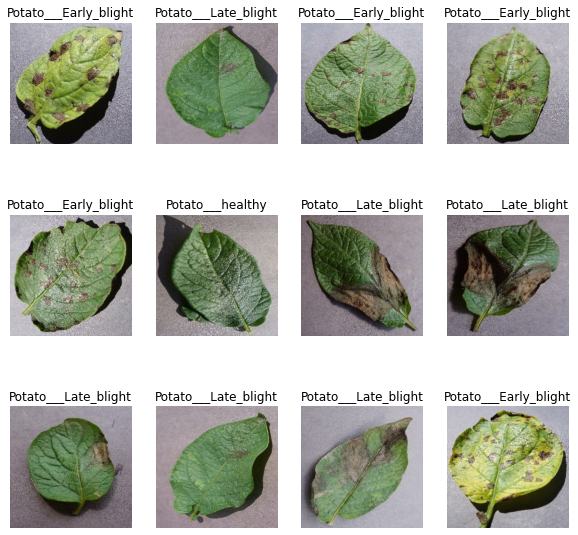

In [10]:
#Visualize some of the images from our dataset for multiple image
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))# converted into int
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training
2.Validation: Dataset to be tested against while training
3.Test: Dataset to be tested against after we trained a model

In [11]:
len(dataset)

68

In [12]:
#80% = training
#20% = 10% validation, 10% test # 10% to measure the accuracy

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54) # 1st 54 data are skip
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)# seed for same result
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [24]:
#Pipeline= We will first do caching this will read the image from the disk and then for the next iteration when you need the same image it will keep that image in the memory, so this improves the performance of your pipeline again.
#Prefetch if you are using GPU and CPU if GPU is busy training pre-petch will load the next set of batch from your disk and that will improve the performance.
#When ypo use prefetch and caching while GPU training batch is one CPU will be loading that batch this is prefetch basically,and cache is basically save the time reading those images 

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

 #Building the Model

Creating a Layer for Resizing and Normalization


Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [27]:
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

 Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
) # Accuracy is the metric that we use to kind of track the training your training process

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 53s 940ms/step - loss: 0.8637 - accuracy: 0.5579 - val_loss: 0.6026 - val_accuracy: 0.7812
Epoch 2/50
54/54 [==============================] - 50s 913ms/step - loss: 0.5054 - accuracy: 0.7865 - val_loss: 0.3417 - val_accuracy: 0.8750
Epoch 3/50
54/54 [==============================] - 47s 872ms/step - loss: 0.3371 - accuracy: 0.8582 - val_loss: 0.3601 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 45s 827ms/step - loss: 0.2806 - accuracy: 0.8912 - val_loss: 0.4177 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 47s 862ms/step - loss: 0.2460 - accuracy: 0.9068 - val_loss: 0.2449 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 47s 875ms/step - loss: 0.1944 - accuracy: 0.9265 - val_loss: 0.3165 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 49s 908ms/step - loss: 0.1870 - accuracy: 0.9184 - val_loss: 0.2057 - val_accuracy: 0.9115

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 199ms/step - loss: 0.0057 - accuracy: 1.0000


In [35]:
scores # Scores is just a list containing loss and accuracy value

[0.005691498517990112, 1.0]

In [36]:
#Plotting the Accuracy and Loss Curves

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [39]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

50

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.863666832447052,
 0.5053992867469788,
 0.33705025911331177,
 0.2806084454059601,
 0.2460002303123474]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

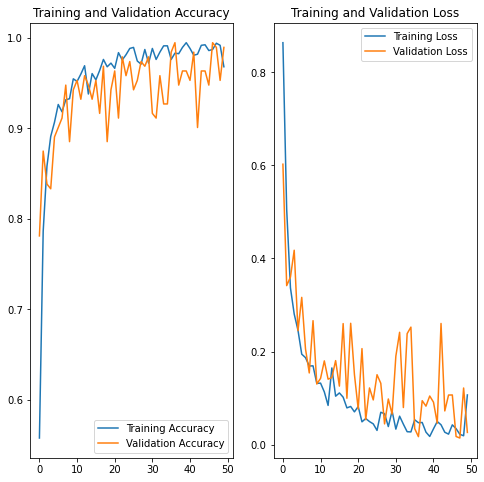

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
#Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 321ms/step
predicted label: Potato___Early_blight


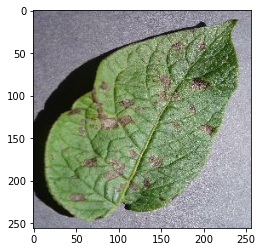

In [46]:
# When you run this all the time it will give you different images with actual label and predicted label because of Convolutional Neural Network.
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

 Function for inference

In [47]:
#The inference scope contains functions to permit explicit management of inference relationships that represent data provenance in the model
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [48]:
# Now run inference on few sample images

1/1 [==============================] - 0s 22ms/step


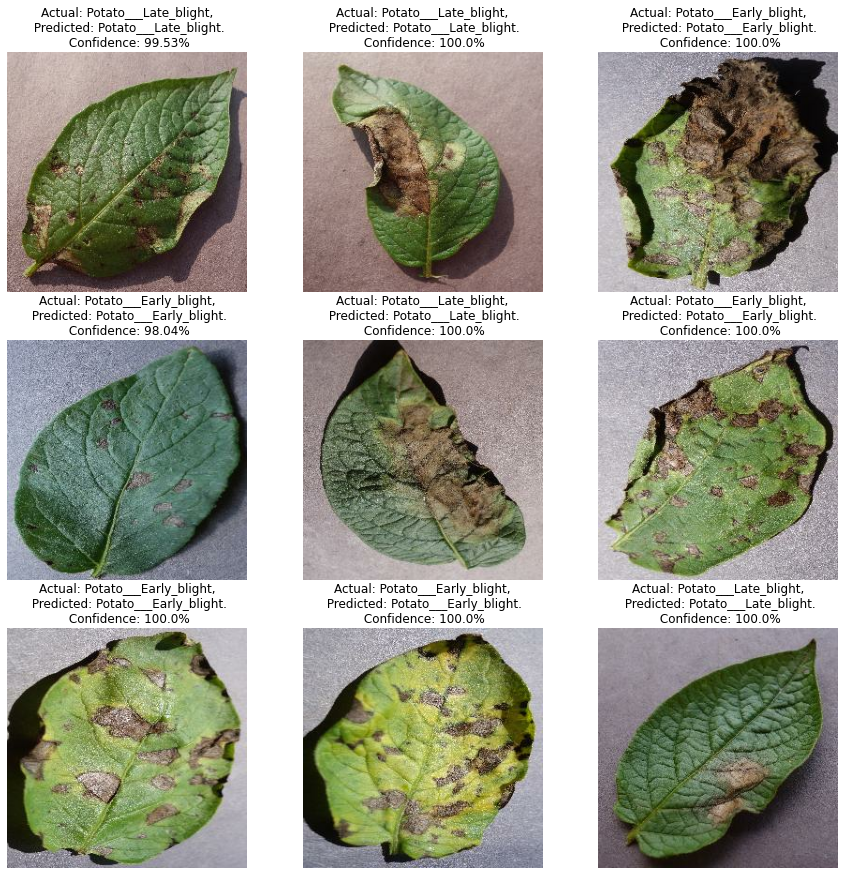

In [49]:
plt.figure(figsize=(15, 15)) 
for images, labels in test_ds.take(1):
    for i in range(9): # we can increase the images number
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [50]:
predict(model,'https://www.syngenta.ca/pests/disease/en/early-blight/Potatoes')

1/1 [==============================] - 0s 29ms/step


('Potato___Late_blight', 100.0)

In [51]:
predict(model,"https://www.researchgate.net/figure/mage-samples-of-potato-leaves-a-healthful-cases-b-early-blight-cases-c-late-blight_fig6_344207488" )

1/1 [==============================] - 0s 20ms/step


('Potato___Late_blight', 100.0)

1/1 [==============================] - 0s 23ms/step
('Potato___Late_blight', 100.0)


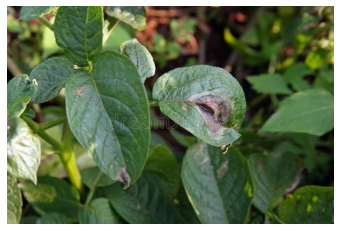

In [52]:
newimg1 = plt.imread("leaf.jpg")
plt.imshow(newimg1.astype("uint8"))
plt.axis("off")
print(predict(model,"leaf.jpg"))